In [1]:
from api_dados import *
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


# listar estações do paraná
estacoes_pr = listar_estacoes_ana(produto='vazao', state='PARANÁ')
codigos = estacoes_pr['Code'].tolist()

print(f"Total de estações no Paraná: {len(codigos)}")
print("Fazendo download das séries")

# baixar dados e calcular falhas
periodos = []
series_dict = {}

for i, codigo in enumerate(codigos, 1):
    try:
        dados = coletar_dados('ana', 'vazao', estacoes=[codigo])
        
        if not dados.empty and codigo in dados.columns:
            serie = dados[codigo]
            dados_validos = serie.dropna()
            
            if not dados_validos.empty:
                ano_inicio = dados_validos.index.min().year
                ano_fim = dados_validos.index.max().year
                n_anos = ano_fim - ano_inicio + 1
                
                periodo_completo = serie.loc[dados_validos.index.min():dados_validos.index.max()]
                total_dias = len(periodo_completo)
                dias_com_dados = len(dados_validos)
                dias_faltantes = total_dias - dias_com_dados
                porcentagem_dados = (dias_com_dados / total_dias) * 100
                porcentagem_falhas = (dias_faltantes / total_dias) * 100
                
                periodos.append({
                    'Code': codigo,
                    'City': estacoes_pr[estacoes_pr['Code'] == codigo]['City'].values[0],
                    'State': estacoes_pr[estacoes_pr['Code'] == codigo]['State'].values[0],
                    'Latitude': estacoes_pr[estacoes_pr['Code'] == codigo]['Latitude'].values[0],
                    'Longitude': estacoes_pr[estacoes_pr['Code'] == codigo]['Longitude'].values[0],                    
                    'Start_Year': ano_inicio,
                    'End_Year': ano_fim,
                    'Years': n_anos,
                    'Total_Days': total_dias,
                    'Days_With_Data': dias_com_dados,
                    'Missing_Days': dias_faltantes,
                    'Data_Percentage': round(porcentagem_dados, 2),
                    'Missing_Percentage': round(porcentagem_falhas, 2)
                })
                
                series_dict[codigo] = serie
        
        # progresso a cada x estações
        if i % 100 == 0:
            print(f"{i}/{len(codigos)} estações processadas...")
            
    except:
        pass


df_periodos = pd.DataFrame(periodos)

Total de estações no Paraná: 1125
Fazendo download das séries


100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


200/1125 estações processadas...


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


300/1125 estações processadas...


100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


600/1125 estações processadas...


100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


700/1125 estações processadas...


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


1100/1125 estações processadas...


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


In [2]:
# filtrar

if len(df_periodos) > 0:
    df_periodos = df_periodos.sort_values('Start_Year')
    
    df_filtrado = df_periodos[
        (df_periodos['Years'] >= 30) & 
        (df_periodos['End_Year'] > 2020) &
        (df_periodos['Data_Percentage'] >= 100)
    ]
    
    print(f"Total de estações: {len(df_periodos)}")
    print(f"Estações selecionadas: {len(df_filtrado)}")
    if len(df_filtrado) > 0:
        print(f"Qualidade média: {df_filtrado['Data_Percentage'].mean():.2f}%")
    
    codigos_filtrados = df_filtrado['Code'].tolist()
    series_filtradas = {codigo: series_dict[codigo] for codigo in codigos_filtrados if codigo in series_dict}
        

# remover NaNs do inicio das series
for codigo in series_filtradas.keys():
    serie = series_filtradas[codigo]   
    series_filtradas[codigo] = serie.loc[serie.first_valid_index():serie.last_valid_index()]


Total de estações: 470
Estações selecionadas: 31
Qualidade média: 100.00%


In [3]:
# caracterizar estiagem

QUANTIL= 0.10 # Q90
MESES_CONSECUTIVOS= 3 # duração para ser estiagem
ANO_INICIO= 2020
ANO_FIM= 2020

caracteristicas_ref = {}

for codigo, serie in series_filtradas.items():
    serie_mensal = serie.resample('M').mean()
    
    periodo_ref = serie_mensal[
        (serie_mensal.index.year >= ANO_INICIO) & 
        (serie_mensal.index.year <= ANO_FIM)
    ]
    
    historico = serie_mensal[serie_mensal.index.year < ANO_INICIO]
    q_limiar = historico.quantile(QUANTIL)
    
    abaixo_limiar = periodo_ref < q_limiar # máscara booleana
    
    # calcular média móvel apenas onde os 3 meses estão abaixo do limiar
    janelas_validas = []
    for i in range(len(periodo_ref) - MESES_CONSECUTIVOS + 1):
        janela_atual = periodo_ref.iloc[i:i+MESES_CONSECUTIVOS]
        mask_atual = abaixo_limiar.iloc[i:i+MESES_CONSECUTIVOS]
        
        if mask_atual.all():
            janelas_validas.append({
                'inicio': janela_atual.index[0],
                'fim': janela_atual.index[-1],
                'vazao_media': janela_atual.mean()
            })
    
    # escolher a janela com menor vazão média
    if len(janelas_validas) > 0:
        janela_minima = min(janelas_validas, key=lambda x: x['vazao_media'])
        
        caracteristicas_ref[codigo] = {
            'duracao_meses': MESES_CONSECUTIVOS,
            'vazao_media_estiagem': janela_minima['vazao_media'],
            'periodo_inicio': janela_minima['inicio'],
            'periodo_fim': janela_minima['fim'],
            'q_limiar': q_limiar
        }


# manter apenas as series que tiveram estiagem no dicionario
series_filtradas = {codigo: serie for codigo, serie in series_filtradas.items() 
                    if codigo in caracteristicas_ref}


print(f"{len(caracteristicas_ref)} séries com estiagem")

25 séries com estiagem


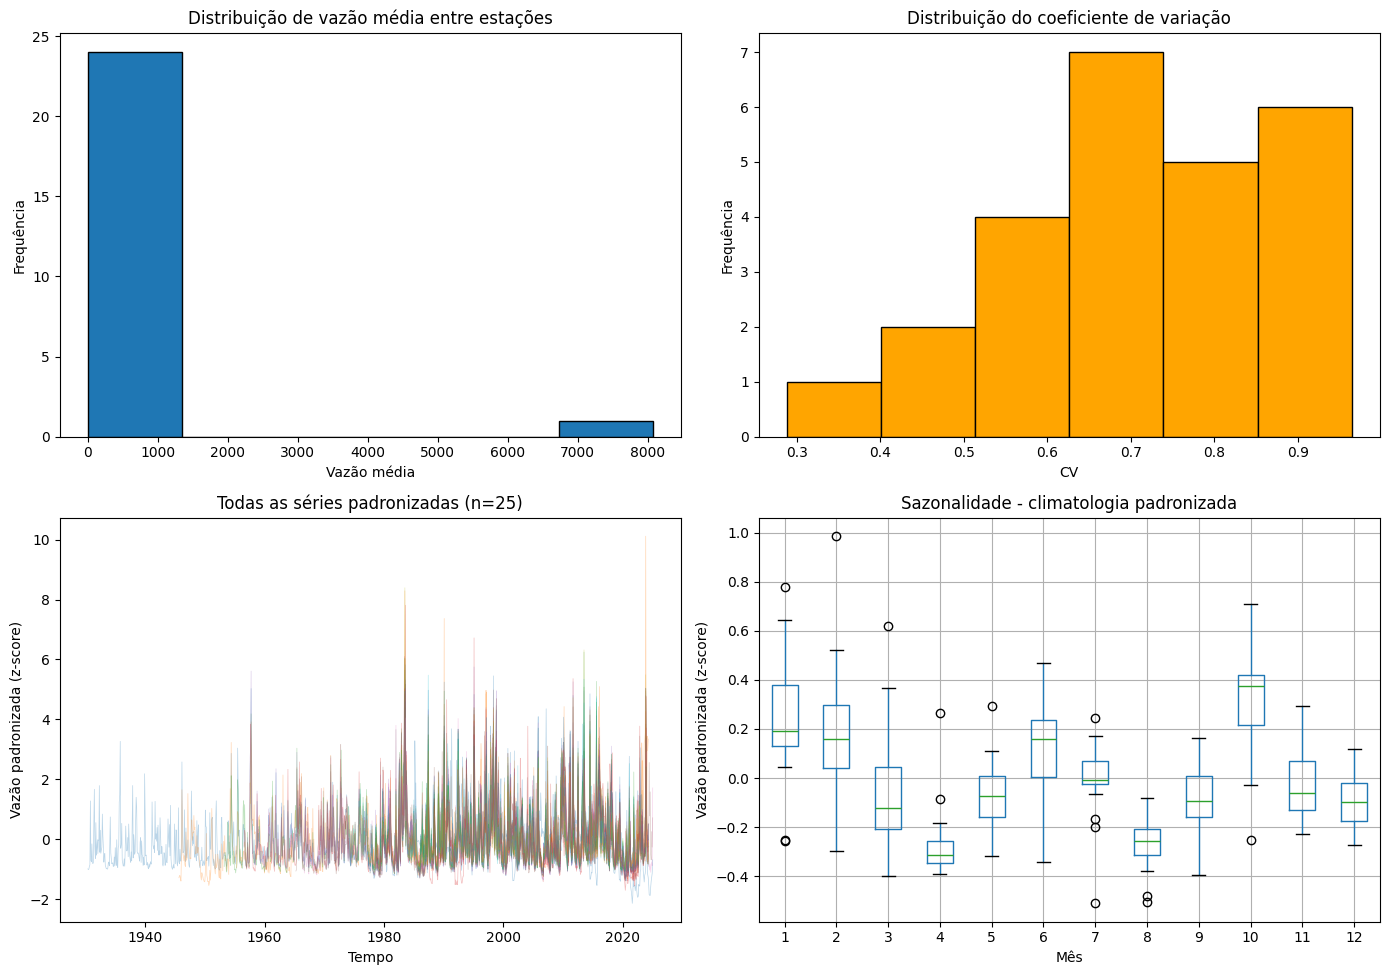

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# (a) Distribuição das vazões médias por estação
vazoes_medias = [serie.resample('M').mean().mean() for serie in series_filtradas.values()]
axes[0,0].hist(vazoes_medias, bins='rice', edgecolor='black')
axes[0,0].set_title('Distribuição de vazão média entre estações')
axes[0,0].set_xlabel('Vazão média')
axes[0,0].set_ylabel('Frequência')

# (b) Distribuição do CV (coef. variação)
cvs = [serie.resample('M').mean().std()/serie.resample('M').mean().mean() 
       for serie in series_filtradas.values()]
axes[0,1].hist(cvs, bins='rice', edgecolor='black', color='orange')
axes[0,1].set_title('Distribuição do coeficiente de variação')
axes[0,1].set_xlabel('CV')
axes[0,1].set_ylabel('Frequência')
axes[0,1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# (c) Todas as séries sobrepostas (normalizadas)
for serie in series_filtradas.values():
    serie_mensal = serie.resample('M').mean()
    serie_norm = (serie_mensal - serie_mensal.mean()) / serie_mensal.std()
    axes[1,0].plot(serie_mensal.index, serie_norm, alpha=0.3, linewidth=0.5)
axes[1,0].set_title(f'Todas as séries padronizadas (n={len(series_filtradas)})')
axes[1,0].set_xlabel('Tempo')
axes[1,0].set_ylabel('Vazão padronizada (z-score)')

# (d) Sazonalidade com climatologia normalizada
dados_clim_norm = []
for serie in series_filtradas.values():
    serie_mensal = serie.resample('M').mean()
    # Normalizar primeiro
    serie_norm = (serie_mensal - serie_mensal.mean()) / serie_mensal.std()
    # Depois calcular climatologia (média de cada mês)
    climatologia_norm = serie_norm.groupby(serie_norm.index.month).mean()
    clim_df = climatologia_norm.to_frame()
    clim_df.columns = ['vazao_norm']
    clim_df['mes'] = clim_df.index
    dados_clim_norm.append(clim_df)

df_clim_norm = pd.concat(dados_clim_norm)
df_clim_norm.boxplot(column='vazao_norm', by='mes', ax=axes[1,1])
axes[1,1].set_title('Sazonalidade - climatologia padronizada')
axes[1,1].set_xlabel('Mês')
axes[1,1].set_ylabel('Vazão padronizada (z-score)')
plt.sca(axes[1,1])
plt.xticks(range(1, 13))

fig.suptitle('') 
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

def extrair_minimos_anuais_mm3(serie_diaria,
                               janela_meses=3,
                               ano_inicio=None,
                               ano_fim=None):
    seriemensal = serie_diaria.resample('M').mean().dropna()

    if ano_inicio is not None:
        seriemensal = seriemensal[seriemensal.index.year >= ano_inicio]
    if ano_fim is not None:
        seriemensal = seriemensal[seriemensal.index.year <= ano_fim]

    if len(seriemensal) < 12:
        return pd.Series(dtype=float)

    mm = seriemensal.rolling(
        window=janela_meses,
        min_periods=janela_meses
    ).mean()

    df = mm.to_frame(name='qmm')
    df['ano'] = df.index.year
    min_anuais = df.groupby('ano')['qmm'].min().dropna()
    return min_anuais

minimos_por_estacao = {}

for codigo, serie in series_filtradas.items():  # TODAS as séries
    min_anuais = extrair_minimos_anuais_mm3(
        serie,
        janela_meses=3,
        ano_inicio=None,   # ou, por ex., 1930
        ano_fim=None       # ou 2019, se quiser excluir 2020
    )
    if len(min_anuais) >= 15:   # mínimo de anos para o KS ter sentido
        minimos_por_estacao[codigo] = min_anuais

from scipy.stats import (
    genextreme, gumbel_r, lognorm, gamma, weibull_min, pearson3, kstest
)

dists_candidatas = {
    'gev':         genextreme,
    'gumbel_r':    gumbel_r,
    'lognorm':     lognorm,
    'gamma':       gamma,
    'weibull_min': weibull_min,
    'pearson3':    pearson3,
}

def testar_distribuicoes_minimos_KS(x,
                                    alpha=0.05,
                                    dists=dists_candidatas):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]

    resultados = []

    for nome, dist in dists.items():
        try:
            params = dist.fit(x)
            frozen = dist(*params)
            D, p_ks = kstest(x, frozen.cdf)

            resultados.append({
                'dist': nome,
                'KS_D': D,
                'KS_p': p_ks,
                'aceita_KS': p_ks > alpha,
                'params': params,
            })
        except Exception:
            resultados.append({
                'dist': nome,
                'KS_D': np.nan,
                'KS_p': np.nan,
                'aceita_KS': False,
                'params': None,
            })

    df_res = (
        pd.DataFrame(resultados)
        .set_index('dist')
        .sort_values('KS_p', ascending=False)
    )
    return df_res

detalhes_por_estacao = {}
linhas_resumo = []

for codigo, min_anuais in minimos_por_estacao.items():
    x = min_anuais.values

    df_fit = testar_distribuicoes_minimos_KS(x, alpha=0.05)
    detalhes_por_estacao[codigo] = df_fit

    n_anos = len(x)
    n_aceitas = int(df_fit['aceita_KS'].sum())
    best_dist = df_fit.index[0] if len(df_fit) > 0 else None  # maior p-valor

    linhas_resumo.append({
        'codigo': codigo,
        'n_anos': n_anos,
        'n_dists_aceitas': n_aceitas,
        'best_dist': best_dist,
    })

df_resumo_fits = (
    pd.DataFrame(linhas_resumo)
    .set_index('codigo')
    .sort_index()
)

print(df_resumo_fits)

          n_anos  n_dists_aceitas    best_dist
codigo                                        
64362000      48                6  weibull_min
64442800      45                6      lognorm
64501000      46                6  weibull_min
64506000      35                6     gumbel_r
64575003      40                3     pearson3
64619950      41                6        gamma
64620000      92                6      lognorm
64625000      69                6        gamma
64660500      39                6  weibull_min
64675002      50                6  weibull_min
64685000      72                6  weibull_min
64693000      51                6     gumbel_r
64764000      38                6     pearson3
64820000      59                6  weibull_min
64830000      56                6     gumbel_r
65020995      38                6  weibull_min
65025000      49                6  weibull_min
65809000      40                6          gev
65925000      60                6  weibull_min
65945000     

In [6]:
from scipy.stats import shapiro

def avaliar_e_transformar_series(series_dict, alpha=0.05, eps=1e-6):

    series_transformadas = {}
    resultados = []
    informacoes_transf = {}

    for codigo, serie in series_dict.items():
        # aqui assumo que a série pode ser diária: agrego para mensal
        serie_mensal = serie.resample('M').mean().dropna()
        dados = serie_mensal.values.astype(float)

        # 0) escala original
        stat_orig, p_orig = shapiro(dados)

        melhor_dados = dados.copy()
        melhor_p = p_orig
        metodo = 'nenhuma'
        meta = {'metodo': 'nenhuma', 'params': {}}

        # preparar deslocamento para garantir positividade
        shift = 0.0
        dados_pos = dados.copy()
        if np.min(dados_pos) <= 0:
            shift = -np.min(dados_pos) + eps
            dados_pos = dados_pos + shift

        # 2) Log com deslocamento
        dados_log = np.log(dados_pos)
        stat_log, p_log = shapiro(dados_log)
        if p_log > melhor_p:
            melhor_dados = dados_log
            melhor_p = p_log
            metodo = 'log_shift'
            meta = {
                'metodo': 'log_shift',
                'params': {
                    'shift': float(shift)
                }
            }

        # salvar série transformada e resumo
        serie_transformada = pd.Series(melhor_dados, index=serie_mensal.index)
        series_transformadas[codigo] = serie_transformada

        resultados.append({
            'codigo': codigo,
            'p_original': p_orig,
            'normal_original': p_orig > alpha,
            'p_transformada': melhor_p,
            'normal_transformada': melhor_p > alpha,
            'metodo': metodo
        })
        informacoes_transf[codigo] = meta

    return series_transformadas, pd.DataFrame(resultados), informacoes_transf



def inverter_series_transformadas(series_transformadas, informacoes_transf):
    series_destransformadas = {}
    for codigo, serie_transf in series_transformadas.items():
        meta = informacoes_transf[codigo]
        metodo = meta['metodo']
        params = meta.get('params', {})
        z = serie_transf.values.astype(float)

        if metodo == 'nenhuma':
            dados_orig = z

        elif metodo == 'log_shift':
            shift = params['shift']
            dados_pos = np.exp(z)
            dados_orig = dados_pos - shift

        else:
            dados_orig = z  # fallback

        series_destransformadas[codigo] = pd.Series(dados_orig, index=serie_transf.index)

    return series_destransformadas


series_vazao_transf, resultados_transf, info_transf = avaliar_e_transformar_series(series_filtradas)

Melhoria na normalidade: 25 de 25 estações
Séries com melhoria < 0.01: 13


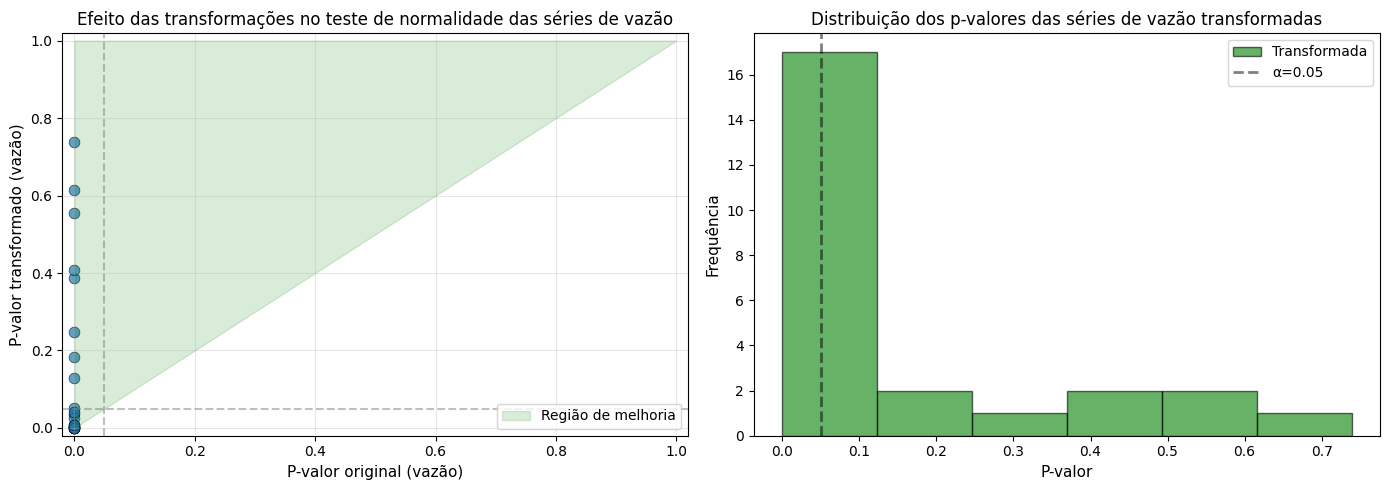

In [7]:
melhoria = resultados_transf['p_transformada'] - resultados_transf['p_original']
print(f"Melhoria na normalidade: {sum(i > 0 for i in melhoria)} de {len(resultados_transf)} estações")
print(f"Séries com melhoria < 0.01: {(melhoria < 0.01).sum()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Gráfico de dispersão - p-valor antes vs depois
axes[0].scatter(resultados_transf['p_original'], 
                resultados_transf['p_transformada'], 
                alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Sombrear região de melhoria
axes[0].fill_between([0, 1], [0, 1], [1, 1], alpha=0.15, color='green', 
                      label='Região de melhoria')

# Linhas do limiar α=0.05
axes[0].axhline(0.05, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
axes[0].axvline(0.05, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)

# Texto informativo
pct_melhorou = ((resultados_transf['p_transformada'] > 
                 resultados_transf['p_original']).sum() / 
                len(resultados_transf) * 100)

axes[0].set_xlabel('P-valor original (vazão)', fontsize=11)
axes[0].set_ylabel('P-valor transformado (vazão)', fontsize=11)
axes[0].set_title('Efeito das transformações no teste de normalidade das séries de vazão', 
                  fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)
axes[0].set_xlim(-0.02, 1.02)
axes[0].set_ylim(-0.02, 1.02)

# (b) Histograma de p-valores
axes[1].hist(resultados_transf['p_transformada'], bins='rice', alpha=0.6, 
             label='Transformada', color='green', edgecolor='black')
axes[1].axvline(0.05, color='black', linestyle='--', linewidth=2, alpha=0.5, 
                label='α=0.05')

axes[1].set_xlabel('P-valor', fontsize=11)
axes[1].set_ylabel('Frequência', fontsize=11)
axes[1].set_title('Distribuição dos p-valores das séries de vazão transformadas', 
                  fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()

In [8]:
import pyhomogeneity as hg
import statsmodels.api as sm

def detectar_quebras_pettitt(serie_mensal, min_anos, max_quebras, alpha):
    """
    Detecta até `max_quebras` pontos de mudança (nível) usando o teste de Pettitt
    aplicado de forma recursiva.

    Retorna lista ordenada de timestamps das quebras.
    """
    serie_mensal = serie_mensal.dropna()
    idx = serie_mensal.index
    min_len = int(min_anos * 12)

    quebras = []
    n_quebras = 0

    def _recursive(segment):
        nonlocal quebras, n_quebras
        if n_quebras >= max_quebras:
            return

        seg_idx = segment.index
        y = segment.values.reshape(-1, 1)

        # precisa ter espaço suficiente para dividir em dois segmentos úteis
        if len(segment) < 2 * min_len:
            return

        h, cp, p, U, mu = hg.pettitt_test(y, alpha=alpha)
        if not h:
            return

        # evitar quebras muito próximas das bordas
        if cp < min_len or (len(segment) - (cp + 1)) < min_len:
            return

        t_break = seg_idx[cp]
        quebras.append(t_break)
        n_quebras += 1

        if n_quebras >= max_quebras:
            return

        left = segment.iloc[:cp+1]
        right = segment.iloc[cp+1:]

        _recursive(left)
        _recursive(right)

    _recursive(serie_mensal)

    quebras = sorted(set(quebras))[:max_quebras]
    return quebras

def ajustar_tendencia_piecewise(y, idx, datas_quebra):
    """
    Ajusta tendência linear por trechos contínua e retorna:
    - tendencia (Series)
    - betas_segmentos (lista de dicts)
    - caract_tendencia (inclinação/intercepto médios globais)
    """
    n = len(y)
    pontos = [0]
    for dt in datas_quebra:
        pontos.append(np.searchsorted(idx, dt, side='right'))
    pontos.append(n)
    pontos = sorted(set(pontos))
    segmentos = [(pontos[i], pontos[i+1]) for i in range(len(pontos)-1)]

    tendencia = np.zeros_like(y, dtype=float)
    betas = []

    for j, (s, e) in enumerate(segmentos):
        t_seg = np.arange(e - s)
        X_seg = sm.add_constant(t_seg)
        y_seg = y[s:e]
        beta = sm.OLS(y_seg, X_seg).fit().params
        slope = float(beta[1])

        if j == 0:
            intercept = float(beta[0])
            tendencia[s:e] = intercept + slope * t_seg
        else:
            intercept = tendencia[s-1]
            tendencia[s:e] = intercept + slope * t_seg

        betas.append({
            'inicio': idx[s],
            'fim': idx[e-1],
            'intercepto': intercept,
            'inclinacao': slope
        })

    tendencia = pd.Series(tendencia, index=idx)

    # resumo global da tendência (equivalente ao extrair_caracteristicas_tendencia)
    x = np.arange(len(tendencia))
    y_t = tendencia.values
    mask = ~np.isnan(y_t)
    coef = np.polyfit(x[mask], y_t[mask], 1)
    caract_tendencia = {
        'inclinacao': coef[0],
        'intercepto': coef[1],
        'valor_inicial': y_t[mask][0],
        'valor_final': y_t[mask][-1]
    }

    return tendencia, betas, caract_tendencia


def decompor_piecewise_linear_pettitt(serie_mensal, min_anos, max_quebras, periodo, alpha):
    serie_mensal = serie_mensal.dropna()
    idx = serie_mensal.index
    y = serie_mensal.values

    # 1) quebras
    datas_quebra = detectar_quebras_pettitt(serie_mensal, min_anos=min_anos,
                                            max_quebras=max_quebras, alpha=alpha)

    # 2) tendência por trechos + características
    tendencia, betas, caract_tendencia = ajustar_tendencia_piecewise(y, idx, datas_quebra)

    # 3) sazonalidade determinística (média mensal dos resíduos)
    resid_trend = y - tendencia.values
    meses = idx.month
    sazonal_mes = pd.Series(resid_trend, index=idx).groupby(meses).mean()
    sazonal_vals = np.array([sazonal_mes[m] for m in meses])
    sazonal = pd.Series(sazonal_vals, index=idx)

    # padrão sazonal médio
    n_periodos = len(sazonal) // periodo
    sazonal_matrix = sazonal.values[:n_periodos*periodo].reshape(n_periodos, periodo)
    padrao_sazonal = sazonal_matrix.mean(axis=0)

    # 4) ruído
    ruido_vals = y - tendencia.values - sazonal.values
    ruido = pd.Series(ruido_vals, index=idx)

    return {
        'tendencia': tendencia,
        'sazonal': sazonal,
        'ruido': ruido,
        'breaks_datas': datas_quebra,
        'betas_segmentos': betas,
        'caract_tendencia': caract_tendencia,
        'padrao_sazonal': padrao_sazonal,
        'metodo': 'piecewise_linear_pettitt'
    }



decomposicoes = {}
resultados_decomp = []
series_ruido = {}

for codigo, serie in series_vazao_transf.items():
    print(f"\nProcessando: {codigo}")
    serie_mensal = serie.resample('M').mean()

    decomp = decompor_piecewise_linear_pettitt(
        serie_mensal,
        min_anos=0,
        max_quebras=4,
        periodo=12,
        alpha=0.05
    )

    tendencia = decomp['tendencia']
    sazonal = decomp['sazonal']
    ruido = decomp['ruido']
    caract_tendencia = decomp['caract_tendencia']
    padrao_sazonal = decomp['padrao_sazonal']

    media_ruido = ruido.dropna().mean()

    print(f"  Inclinação média da tendência (z): {caract_tendencia['inclinacao']:.6f}")
    print(f"  Média do ruído (z): {media_ruido:.6f}")
    
    # guarda tudo da decomposição
    decomposicoes[codigo] = decomp

    # guarda APENAS o ruído em um dicionário separado
    series_ruido[codigo] = ruido    # <- aqui fica do jeito que você quer

    resultados_decomp.append({
        'codigo': codigo,
        'inclinacao_tendencia': caract_tendencia['inclinacao'],
        'media_ruido': media_ruido
    })

df_decomp = pd.DataFrame(resultados_decomp)



Processando: 64620000
  Inclinação média da tendência (z): 0.000616
  Média do ruído (z): 0.000000

Processando: 81125000
  Inclinação média da tendência (z): -0.000957
  Média do ruído (z): 0.000000

Processando: 64685000
  Inclinação média da tendência (z): 0.000393
  Média do ruído (z): 0.000000

Processando: 65945000
  Inclinação média da tendência (z): 0.000012
  Média do ruído (z): 0.000000

Processando: 64625000
  Inclinação média da tendência (z): -0.000266
  Média do ruído (z): 0.000000

Processando: 65925000
  Inclinação média da tendência (z): 0.000163
  Média do ruído (z): -0.000000

Processando: 64820000
  Inclinação média da tendência (z): -0.000118
  Média do ruído (z): -0.000000

Processando: 64830000
  Inclinação média da tendência (z): 0.000028
  Média do ruído (z): 0.000000

Processando: 64693000
  Inclinação média da tendência (z): -0.001462
  Média do ruído (z): 0.000000

Processando: 64675002
  Inclinação média da tendência (z): 0.000127
  Média do ruído (z): -0.

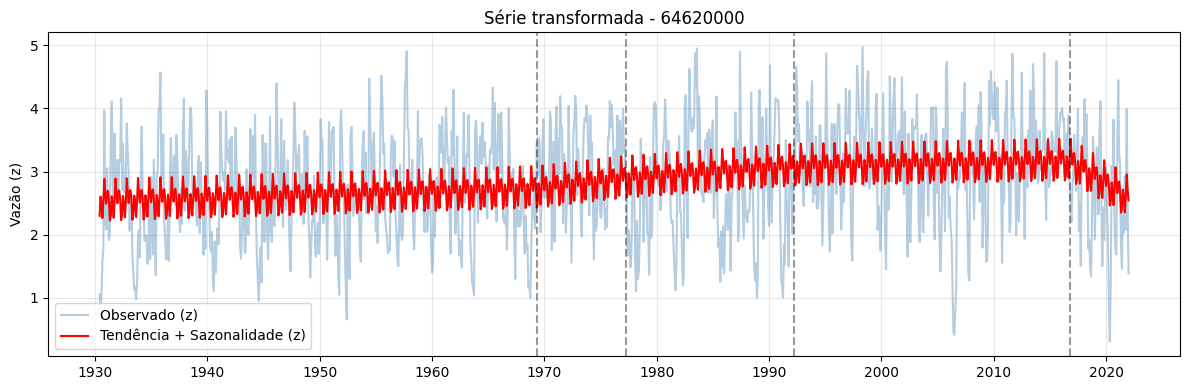


=== Estatísticas da Decomposição - 64620000 ===
Variância total (z): 0.7359
Variância da tendência: 0.0482 (6.6%)
Variância da sazonalidade: 0.0343 (4.7%)
Variância do ruído: 0.6665 (90.6%)

Média do ruído: 0.000000
Número de quebras detectadas: 4


In [9]:
# VISUALIZAR DECOMPOSIÇÃO NO ESPAÇO TRANSFORMADO

codigo_ex = '64620000'  # por exemplo
dec = decomposicoes[codigo_ex]

tend = dec['tendencia']
sazonal = dec['sazonal']
ruido = dec['ruido']

# Usar a série TRANSFORMADA (não a original)
serie_transf = series_vazao_transf[codigo_ex]

# Opcional: também pegar a original para comparação
orig_mensal = series_filtradas[codigo_ex].resample('M').mean()

# %%
# GRÁFICO 3: Qualidade do ajuste (MUITO ÚTIL!)
plt.figure(figsize=(12, 4))

# (a) Série transformada vs Tendência+Sazonalidade
reconstruido = tend + sazonal
plt.plot(serie_transf.index, serie_transf, alpha=0.4, 
             label='Observado (z)', color='steelblue')
plt.plot(reconstruido.index, reconstruido, 'r', 
             label='Tendência + Sazonalidade (z)', linewidth=1.5)
for dt in dec['breaks_datas']:
    plt.axvline(dt, color='k', linestyle='--', alpha=0.4)
plt.ylabel('Vazão (z)')
plt.title(f'Série transformada - {codigo_ex}')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# ESTATÍSTICAS DA DECOMPOSIÇÃO
print(f"\n=== Estatísticas da Decomposição - {codigo_ex} ===")
print(f"Variância total (z): {serie_transf.var():.4f}")
print(f"Variância da tendência: {tend.var():.4f} ({100*tend.var()/serie_transf.var():.1f}%)")
print(f"Variância da sazonalidade: {sazonal.var():.4f} ({100*sazonal.var()/serie_transf.var():.1f}%)")
print(f"Variância do ruído: {ruido.var():.4f} ({100*ruido.var()/serie_transf.var():.1f}%)")
print(f"\nMédia do ruído: {ruido.mean():.6f}")
print(f"Número de quebras detectadas: {len(dec['breaks_datas'])}")

In [10]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

def selecionar_ordem_arma(serie, max_p, max_q):
    melhor_aic = np.inf
    melhor_ordem = None
    
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            if p == 0 and q == 0:
                continue
            try:
                modelo = ARIMA(serie, order=(p, 0, q),
                               enforce_stationarity=True,
                               enforce_invertibility=True)
                res = modelo.fit()
                if res.aic < melhor_aic:
                    melhor_aic = res.aic
                    melhor_ordem = (p, q)
            except:
                continue
    
    return melhor_ordem, melhor_aic

def ajustar_arma(serie, ordem):
    p, q = ordem
    modelo = ARIMA(serie, order=(p, 0, q),
                   enforce_stationarity=True,
                   enforce_invertibility=True)
    resultado = modelo.fit()
    return resultado


modelos_ruido = {}
for codigo in decomposicoes.keys():
    print(f"Série: {codigo}")
    
    # Usar ruído para modelagem ARMA
    ruido_transformado = series_ruido[codigo]
    
    # Selecionar ordem
    ordem, aic = selecionar_ordem_arma(ruido_transformado, max_p=5, max_q=5)
    print(f"Melhor ordem (p,q): {ordem}, AIC: {aic:.2f}")
    
    # Ajustar modelo
    modelo_arma = ajustar_arma(ruido_transformado, ordem)
    modelos_ruido[codigo] = {
        'modelo': modelo_arma,
        'ordem': ordem
    }


Série: 64620000
Melhor ordem (p,q): (1, 0), AIC: 2338.61
Série: 81125000
Melhor ordem (p,q): (2, 2), AIC: 13.69
Série: 64685000
Melhor ordem (p,q): (4, 4), AIC: 1361.53
Série: 65945000
Melhor ordem (p,q): (3, 5), AIC: 1289.69
Série: 64625000
Melhor ordem (p,q): (1, 0), AIC: 1892.25
Série: 65925000
Melhor ordem (p,q): (5, 5), AIC: 1385.05
Série: 64820000
Melhor ordem (p,q): (4, 4), AIC: 1023.57
Série: 64830000
Melhor ordem (p,q): (1, 0), AIC: 907.08
Série: 64693000
Melhor ordem (p,q): (4, 3), AIC: 848.99
Série: 64675002
Melhor ordem (p,q): (3, 5), AIC: 1146.95
Série: 65025000
Melhor ordem (p,q): (2, 1), AIC: 790.11
Série: 64362000
Melhor ordem (p,q): (5, 0), AIC: 981.99
Série: 64501000
Melhor ordem (p,q): (2, 2), AIC: 796.24
Série: 81120000
Melhor ordem (p,q): (3, 5), AIC: 257.47
Série: 81107000
Melhor ordem (p,q): (1, 3), AIC: 321.44
Série: 81102000
Melhor ordem (p,q): (4, 3), AIC: 367.93
Série: 64442800
Melhor ordem (p,q): (1, 1), AIC: 988.74
Série: 81019350
Melhor ordem (p,q): (1, 3)

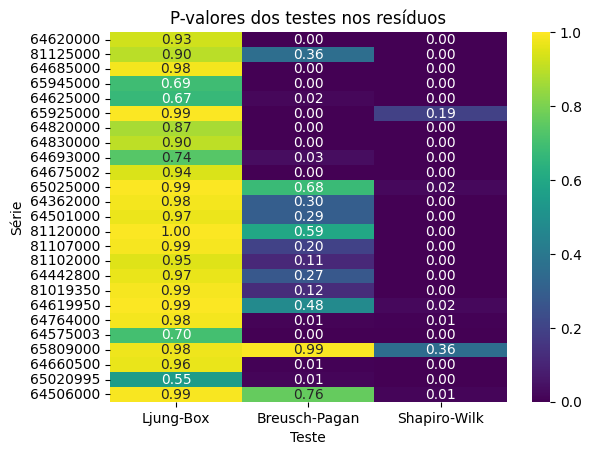

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
import seaborn as sns
import matplotlib.pyplot as plt


def diagnosticar_modelo(resultado_arma):
    residuos = resultado_arma.resid
    
    # Variância dos resíduos
    variancia = np.var(residuos)    
    
    # Teste de Ljung-Box (independencia)
    lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
    
    # Teste de Breusch-Pagan (homocedasticidade)    
    y_fit = resultado_arma.fittedvalues
    X_bp = np.column_stack([
        np.ones_like(y_fit),   # intercepto
        y_fit,                 # valores ajustados
        y_fit**2               # termo quadrático (opcional)
    ])

    bp_lm, bp_lm_p, bp_f, bp_f_p = het_breuschpagan(residuos, X_bp)

    # Teste de Shapiro-Wilk (normalidade)
    shapiro_stat, shapiro_p = shapiro(residuos)
    
    return {
        'variancia': variancia,
        'ljung_box_pvalue': lb_test['lb_pvalue'].values[0],
        'breusch_pagan_pvalue': bp_lm_p,
        'shapiro_pvalue': shapiro_p
    }



tests_list = []
for serie_id, resultado_arma in modelos_ruido.items():
    stats = diagnosticar_modelo(resultado_arma['modelo'])
    tests_list.append({
        'serie': serie_id,
        'Ljung-Box':      stats['ljung_box_pvalue'],
        'Breusch-Pagan':  stats['breusch_pagan_pvalue'],
        'Shapiro-Wilk':   stats['shapiro_pvalue'],
        'variancia':      stats['variancia']
    })

df_tests = pd.DataFrame(tests_list)

mat = df_tests.set_index('serie')[['Ljung-Box', 'Breusch-Pagan', 'Shapiro-Wilk']]

sns.heatmap(mat, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1)
plt.title("P-valores dos testes nos resíduos")
plt.ylabel("Série")
plt.xlabel("Teste")
plt.show()


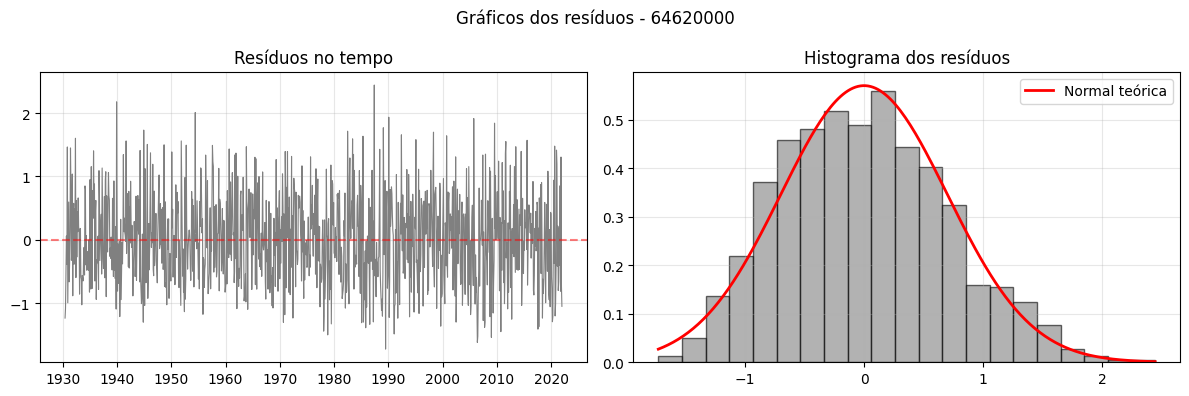

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# apesar do teste recusar a hipotese de normalidade em quase todas as series, o plot da distribuição delas lembra uma normal

def plot_diagnostico_residuos(resultado_arma, serie_id):
    res = resultado_arma.resid

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # (1) série temporal dos resíduos
    axes[0].plot(res.index, res.values, color='gray', linewidth=0.8)
    axes[0].axhline(0, color='r', linestyle='--', alpha=0.5)
    axes[0].set_title('Resíduos no tempo')
    axes[0].grid(alpha=0.3)

    # (2) histograma + normal teórica
    mu, sigma = res.mean(), res.std()
    axes[1].hist(res.values, bins='rice', density=True, alpha=0.6,
                 color='gray', edgecolor='black')
    x = np.linspace(res.min(), res.max(), 200)
    pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
    axes[1].plot(x, pdf, 'r', linewidth=2, label='Normal teórica')
    axes[1].set_title('Histograma dos resíduos')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    fig.suptitle(f'Gráficos dos resíduos - {serie_id}')

    plt.tight_layout()
    plt.show()

serie_id = '64620000'  # por exemplo
resultado_arma = modelos_ruido[serie_id]['modelo']
plot_diagnostico_residuos(resultado_arma, serie_id)


In [13]:
def gerar_ruido_futuro(
    decomposicoes,
    modelos_ruido,
    n_simulacoes=1000):
    
    horizonte_max= 30

    series_ruido_fut_z = {}
    
    for codigo in decomposicoes.keys():
        modelo_arma = modelos_ruido[codigo]['modelo']
        decomp = decomposicoes[codigo]
        ruido_hist = decomp['ruido'].dropna()
        idx_orig = ruido_hist.index
        
        # Gerar apenas para o horizonte máximo
        n_meses = horizonte_max * 12
        last_idx = idx_orig[-1]
        idx_future = pd.date_range(
            start=last_idx + pd.offsets.MonthEnd(1),
            periods=n_meses,
            freq='M'
        )
        
        simulacoes_30 = []
        for _ in range(n_simulacoes):
            z_sim = modelo_arma.simulate(nsimulations=n_meses, anchor='end')
            z_sim = np.asarray(z_sim).flatten()
            serie_z = pd.Series(z_sim, index=idx_future)
            simulacoes_30.append(serie_z)
        
        # Extrair subconjuntos para 5 e 10 anos
        series_ruido_fut_z[codigo] = {
            5: [s.iloc[:60] for s in simulacoes_30],   # primeiros 60 meses
            10: [s.iloc[:120] for s in simulacoes_30],  # primeiros 120 meses
            30: simulacoes_30                           # série completa
        }
    
    return series_ruido_fut_z


# Ruído futuro em escala original
series_ruido_fut = gerar_ruido_futuro(
    decomposicoes=decomposicoes,
    modelos_ruido=modelos_ruido,
    n_simulacoes=1000
)

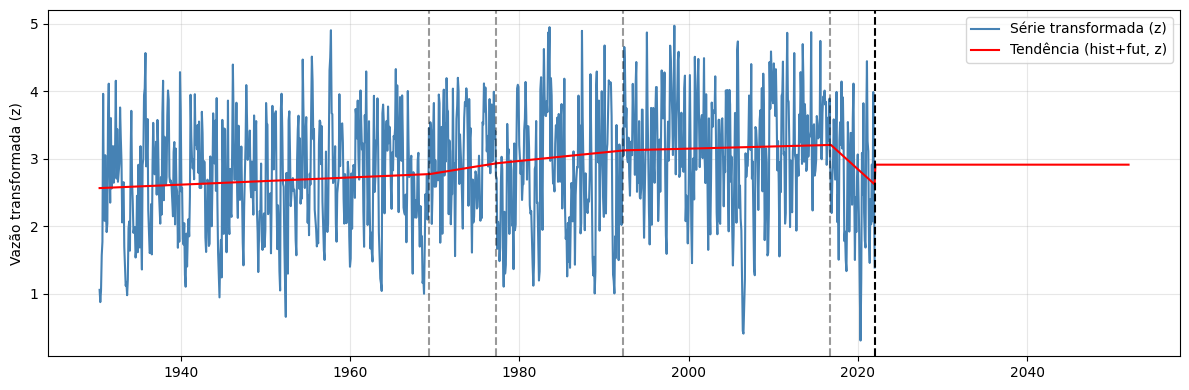

In [14]:
codigo_ex = '64620000'
h_anos = 30

dec = decomposicoes[codigo_ex]

# tendência já na ESCALA TRANSFORMADA (z)
tend_orig = dec['tendencia']
betas     = dec['betas_segmentos']

last_date = tend_orig.index[-1]
n_meses   = h_anos * 12
idx_future = pd.date_range(start=last_date + pd.offsets.MonthEnd(1),
                           periods=n_meses, freq='M')

# --- cálculo da extrapolação na escala transformada (z) ---
last_val    = tend_orig.iloc[-1]
slope_last  = betas[-1]['inclinacao']
inicio_ult  = betas[-1]['inicio']
fim_ult     = betas[-1]['fim']
mask_ult    = (tend_orig.index >= inicio_ult) & (tend_orig.index <= fim_ult)
nivel_medio_ult = tend_orig.loc[mask_ult].mean()

t = np.arange(1, n_meses + 1)
if slope_last >= 0:
    tend_fut_vals = last_val + slope_last * t
else:
    tend_fut_vals = np.full(n_meses, nivel_medio_ult)

tend_fut   = pd.Series(tend_fut_vals, index=idx_future)
tend_total = pd.concat([tend_orig, tend_fut])

# --- aqui entra a MESMA série transformada usada no 2º código ---
serie_transf = series_vazao_transf[codigo_ex]

plt.figure(figsize=(12,4))
plt.plot(serie_transf.index, serie_transf, color='steelblue', #'lightgreen',
         label='Série transformada (z)')
plt.plot(tend_total.index, tend_total, 'r', label='Tendência (hist+fut, z)')
plt.axvline(serie_transf.index[-1], color='k', linestyle='--')
for dt in dec['breaks_datas']:
    plt.axvline(dt, color='k', linestyle='--', alpha=0.4)
plt.ylabel('Vazão transformada (z)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
def gerar_vazao_futura(
    decomposicoes,
    series_ruido_fut,
    horizontes_anos=(5, 10, 30)
):
    
    series_vazao_fut_z = {}

    for codigo, decomp in decomposicoes.items():
        tendencia_orig = decomp['tendencia']
        padrao_sazonal = decomp['padrao_sazonal']
        betas = decomp['betas_segmentos']

        idx_orig = tendencia_orig.index
        last_date = idx_orig[-1]

        inicio_ult = betas[-1]['inicio']
        fim_ult = betas[-1]['fim']
        mask_ult = (tendencia_orig.index >= inicio_ult) & (tendencia_orig.index <= fim_ult)
        nivel_medio_ult = tendencia_orig.loc[mask_ult].mean()

        series_vazao_fut_z[codigo] = {}

        for h_anos in horizontes_anos:
            n_meses = h_anos * 12

            idx_future = pd.date_range(
                start=last_date + pd.offsets.MonthEnd(1),
                periods=n_meses,
                freq='M'
            )

            
            tendencia_fut_vals = np.full(n_meses, nivel_medio_ult)

            tendencia_fut = pd.Series(tendencia_fut_vals, index=idx_future)

            saz_vals = np.array([padrao_sazonal[m - 1] for m in idx_future.month])
            saz_fut = pd.Series(saz_vals, index=idx_future)

            simulacoes_vazao = []
            for ruido_sim_z in series_ruido_fut[codigo][h_anos]:
                ruido_sim_z = ruido_sim_z.reindex(idx_future)
                # SOMA EM Z: T + S + R
                vazao_sim_z = tendencia_fut + saz_fut + ruido_sim_z

                simulacoes_vazao.append(vazao_sim_z)

            series_vazao_fut_z[codigo][h_anos] = simulacoes_vazao

    return series_vazao_fut_z


# Vazões futuras sintéticas
series_vazao_fut = gerar_vazao_futura(
    decomposicoes=decomposicoes,
    series_ruido_fut=series_ruido_fut,
    horizontes_anos=(5, 10, 30)
)

In [16]:
def inverter_series_vazao_futura(
    series_vazao_fut_z,
    info_transf_vazao
):
    series_vazao_fut_q = {}

    for codigo, dict_horizontes in series_vazao_fut_z.items():
        series_vazao_fut_q[codigo] = {}
        for h_anos, lista_series_z in dict_horizontes.items():
            series_vazao_fut_q[codigo][h_anos] = []
            for serie_z in lista_series_z:
                q = inverter_series_transformadas(
                    {codigo: serie_z},
                    info_transf_vazao
                )[codigo]
                series_vazao_fut_q[codigo][h_anos].append(q)

    return series_vazao_fut_q

series_vazao_fut = inverter_series_vazao_futura(
    series_vazao_fut,
    info_transf
)

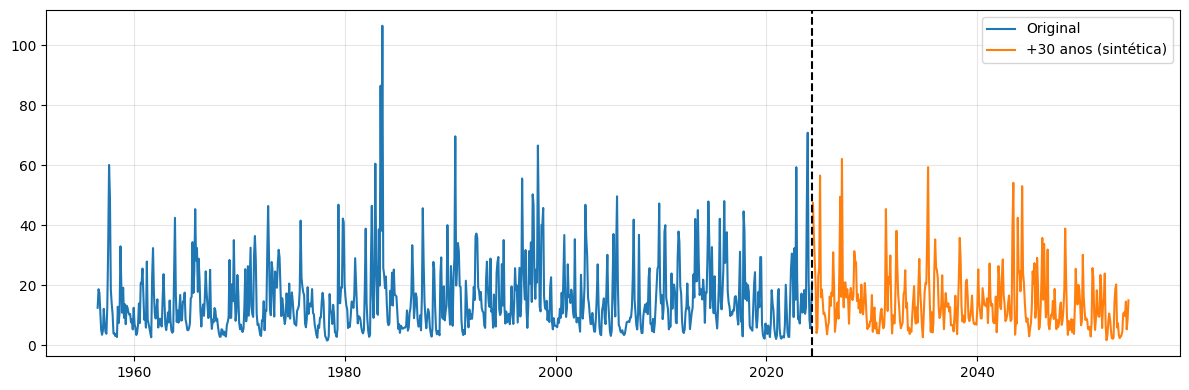

In [17]:
# exemplo de um plot da serie original + uma das series sintetica para o futuro
codigo_ex = list(series_vazao_fut.keys())[3]

vazoes_30anos = series_vazao_fut[codigo_ex][30]
v30 = vazoes_30anos[0]
orig_mensal = series_filtradas[codigo_ex].resample('M').mean()

plt.figure(figsize=(12,4))
plt.plot(orig_mensal.index, orig_mensal, label='Original')
plt.plot(v30.index, v30, label='+30 anos (sintética)')
plt.axvline(orig_mensal.index[-1], color='k', linestyle='--')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# VALIDAÇÃO DAS SÉRIES SINTÉTICAS

codigo_ex = list(series_vazao_fut.keys())[0]

orig = series_filtradas[codigo_ex].resample('M').mean()
sims = series_vazao_fut[codigo_ex][30]

medias = [s.mean() for s in sims]
stds = [s.std() for s in sims]

print(f"\n=== Validação da estação {codigo_ex} ===")
print(f"Média original: {orig.mean():.2f}")
print(f"Média sintética: {np.mean(medias):.2f} ± {np.std(medias):.2f}")
print(f"Desvio padrão original: {orig.std():.2f}")
print(f"Desvio padrão sintético: {np.mean(stds):.2f} ± {np.std(stds):.2f}")


=== Validação da estação 64620000 ===
Média original: 24.54
Média sintética: 24.99 ± 2.24
Desvio padrão original: 21.86
Desvio padrão sintético: 24.69 ± 4.48


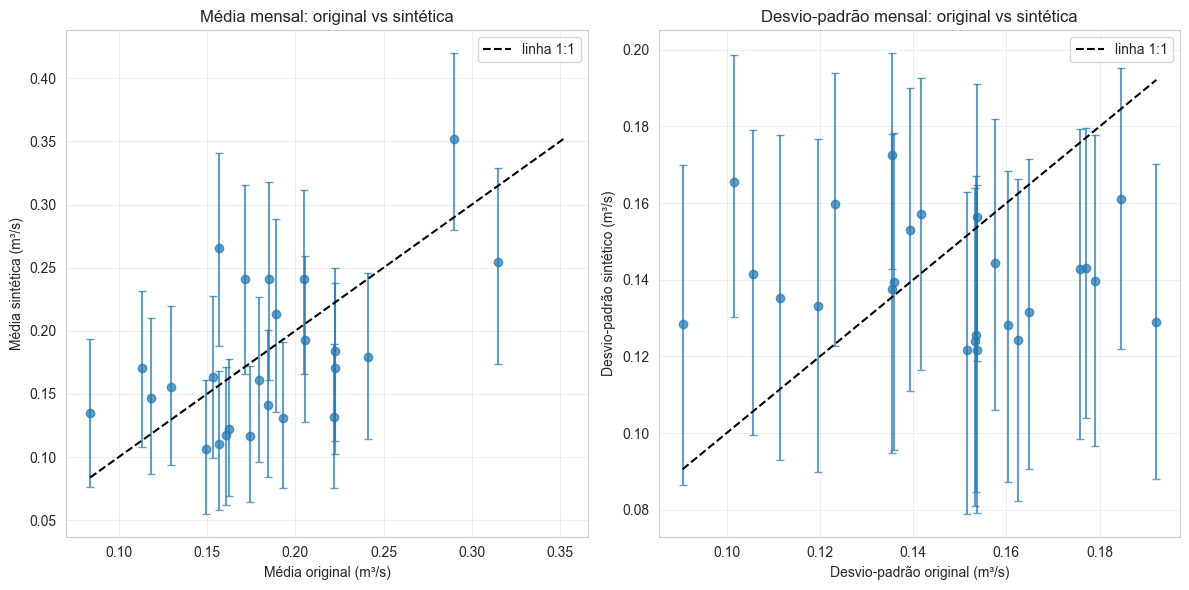

In [33]:
registros = []

def normalizar(serie):
    return (serie - serie.min()) / (serie.max() - serie.min())

for codigo in series_vazao_fut.keys():
    #orig = series_filtradas[codigo].resample('M').mean()
    #sims = series_vazao_fut[codigo][30]
    orig = normalizar(series_filtradas[codigo].resample('M').mean())
    sims = [normalizar(s) for s in series_vazao_fut[codigo][30]]

    medias_sims = np.array([s.mean() for s in sims])
    stds_sims   = np.array([s.std()  for s in sims])


    registros.append({
        'codigo': codigo,
        'mu_orig': orig.mean(),
        'sd_orig': orig.std(),
        'mu_sint_med': medias_sims.mean(),
        'mu_sint_p_p1': np.percentile(medias_sims, 5),   # percentil p1
        'mu_sint_p_p2': np.percentile(medias_sims, 95), # percentil p2
        'sd_sint_med': stds_sims.mean(),
        'sd_sint_p_p1': np.percentile(stds_sims, 5),
        'sd_sint_p_p2': np.percentile(stds_sims, 95)
    })


df_valid = pd.DataFrame(registros).set_index('codigo')


# --- figura com 2 painéis lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


# ---------------- (a) Médias ----------------
ax = axes[0]


ax.errorbar(
    df_valid['mu_orig'],
    df_valid['mu_sint_med'],
    yerr=[df_valid['mu_sint_med'] - df_valid['mu_sint_p_p1'],
          df_valid['mu_sint_p_p2'] - df_valid['mu_sint_med']],
    fmt='o', capsize=3, alpha=0.7
)


min_val = min(df_valid['mu_orig'].min(), df_valid['mu_sint_med'].min())
max_val = max(df_valid['mu_orig'].max(), df_valid['mu_sint_med'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='linha 1:1')


ax.set_xlabel('Média original (m³/s)')
ax.set_ylabel('Média sintética (m³/s)')
ax.set_title('Média mensal: original vs sintética')
ax.grid(alpha=0.3)
ax.legend()


# ---------------- (b) Desvios-padrão ----------------
ax = axes[1]


ax.errorbar(
    df_valid['sd_orig'],
    df_valid['sd_sint_med'],
    yerr=[df_valid['sd_sint_med'] - df_valid['sd_sint_p_p1'],
          df_valid['sd_sint_p_p2'] - df_valid['sd_sint_med']],
    fmt='o', capsize=3, alpha=0.7
)


min_val = min(df_valid['sd_orig'].min(), df_valid['sd_sint_med'].min())
max_val = max(df_valid['sd_orig'].max(), df_valid['sd_sint_med'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='linha 1:1')


ax.set_xlabel('Desvio-padrão original (m³/s)')
ax.set_ylabel('Desvio-padrão sintético (m³/s)')
ax.set_title('Desvio-padrão mensal: original vs sintética')
ax.grid(alpha=0.3)
ax.legend()


plt.tight_layout()
plt.show()

In [20]:
# investigando a serie que possui a maior vazao media, pois suas series sinteticas ficaram longe do valor media da serie original

sds_longotermo = []
medias_longotermo = []

for codigo, serie in series_filtradas.items():
    # média mensal ao longo do período
    serie_mensal = serie.resample('M').mean()
    # média de longo termo (média da série mensal)
    mu_lt = serie_mensal.mean()
    medias_longotermo.append({'codigo': codigo, 'mu_lt': mu_lt})
    sd_lt = serie_mensal.std()
    sds_longotermo.append({'codigo': codigo, 'sd_lt': sd_lt})

df_mu = pd.DataFrame(medias_longotermo).set_index('codigo')
df_sd = pd.DataFrame(sds_longotermo).set_index('codigo')

# código com maior vazão média de longo termo
codigo_max = df_mu['mu_lt'].idxmax()
mu_max = df_mu.loc[codigo_max, 'mu_lt']

# código com maior desvio-padrão de longo termo
codigo_max_sd = df_sd['sd_lt'].idxmax()
sd_max = df_sd.loc[codigo_max_sd, 'sd_lt']

print("Estação com maior vazão média de longo termo:")
print(f"  Código: {codigo_max}")
print(f"  Média de longo termo (m³/s): {mu_max:.2f}")

print("Estação com maior desvio-padrão mensal de longo termo:")
print(f"  Código: {codigo_max_sd}")
print(f"  SD de longo termo (m³/s): {sd_max:.2f}")

Estação com maior vazão média de longo termo:
  Código: 64575003
  Média de longo termo (m³/s): 8069.67
Estação com maior desvio-padrão mensal de longo termo:
  Código: 64575003
  SD de longo termo (m³/s): 2325.56


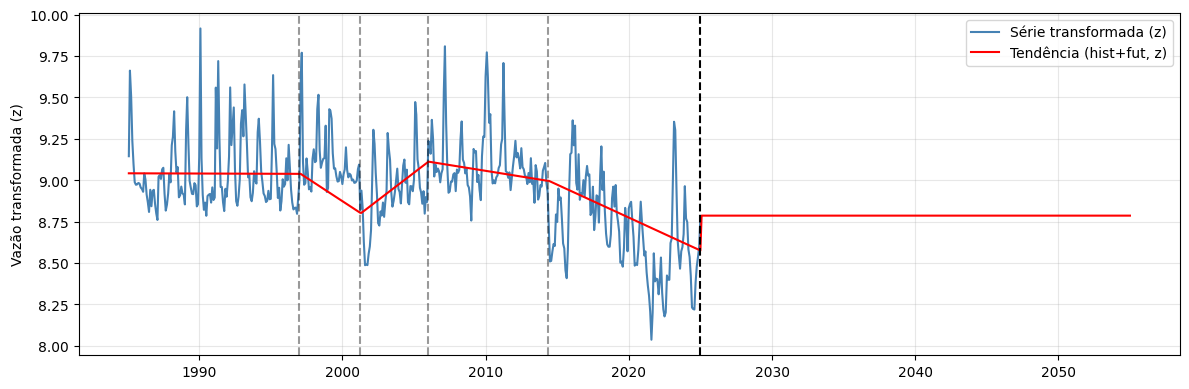

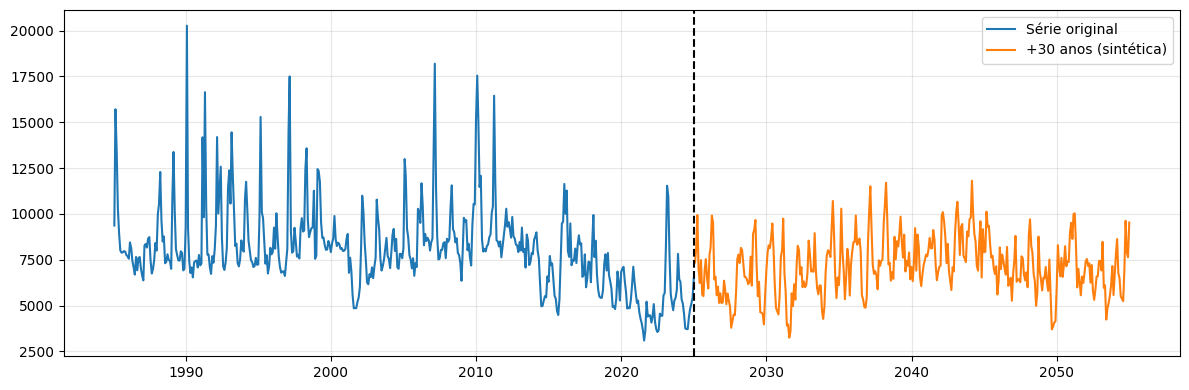

In [21]:
codigo_ex = '64575003'
h_anos = 30

dec = decomposicoes[codigo_ex]

# tendência já na ESCALA TRANSFORMADA (z)
tend_orig = dec['tendencia']
betas     = dec['betas_segmentos']

last_date = tend_orig.index[-1]
n_meses   = h_anos * 12
idx_future = pd.date_range(start=last_date + pd.offsets.MonthEnd(1),
                           periods=n_meses, freq='M')

# --- cálculo da extrapolação na escala transformada (z) ---
last_val    = tend_orig.iloc[-1]
slope_last  = betas[-1]['inclinacao']
inicio_ult  = betas[-1]['inicio']
fim_ult     = betas[-1]['fim']
mask_ult    = (tend_orig.index >= inicio_ult) & (tend_orig.index <= fim_ult)
nivel_medio_ult = tend_orig.loc[mask_ult].mean()

t = np.arange(1, n_meses + 1)
if slope_last >= 0:
    tend_fut_vals = last_val + slope_last * t
else:
    tend_fut_vals = np.full(n_meses, nivel_medio_ult)

tend_fut   = pd.Series(tend_fut_vals, index=idx_future)
tend_total = pd.concat([tend_orig, tend_fut])

# --- aqui entra a MESMA série transformada usada no 2º código ---
serie_transf = series_vazao_transf[codigo_ex]

plt.figure(figsize=(12,4))
plt.plot(serie_transf.index, serie_transf, color='steelblue', #'lightgreen',
         label='Série transformada (z)')
plt.plot(tend_total.index, tend_total, 'r', label='Tendência (hist+fut, z)')
plt.axvline(serie_transf.index[-1], color='k', linestyle='--')
for dt in dec['breaks_datas']:
    plt.axvline(dt, color='k', linestyle='--', alpha=0.4)
plt.ylabel('Vazão transformada (z)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


vazoes_30anos = series_vazao_fut[codigo_ex][30]
v30 = vazoes_30anos[2]
orig_mensal = series_filtradas[codigo_ex].resample('M').mean()

plt.figure(figsize=(12,4))
plt.plot(orig_mensal.index, orig_mensal, label='Série original')
plt.plot(v30.index, v30, label=f'+{h_anos} anos (sintética)')
plt.axvline(orig_mensal.index[-1], color='k', linestyle='--')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

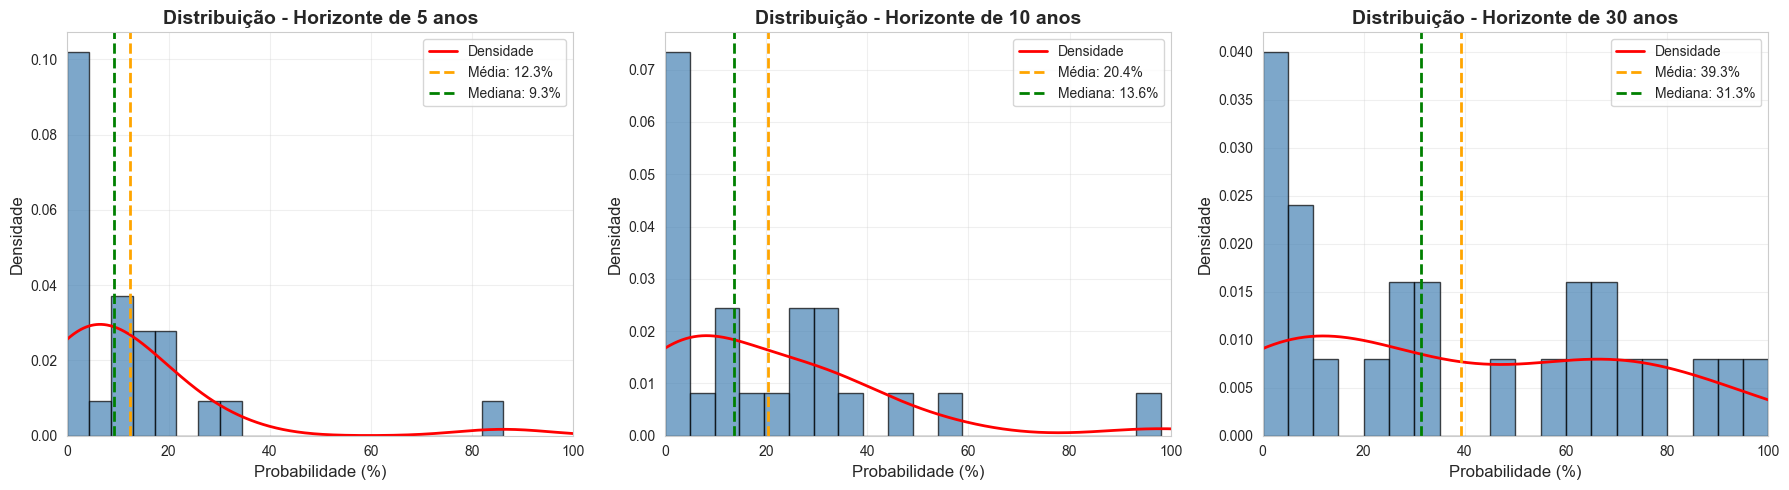

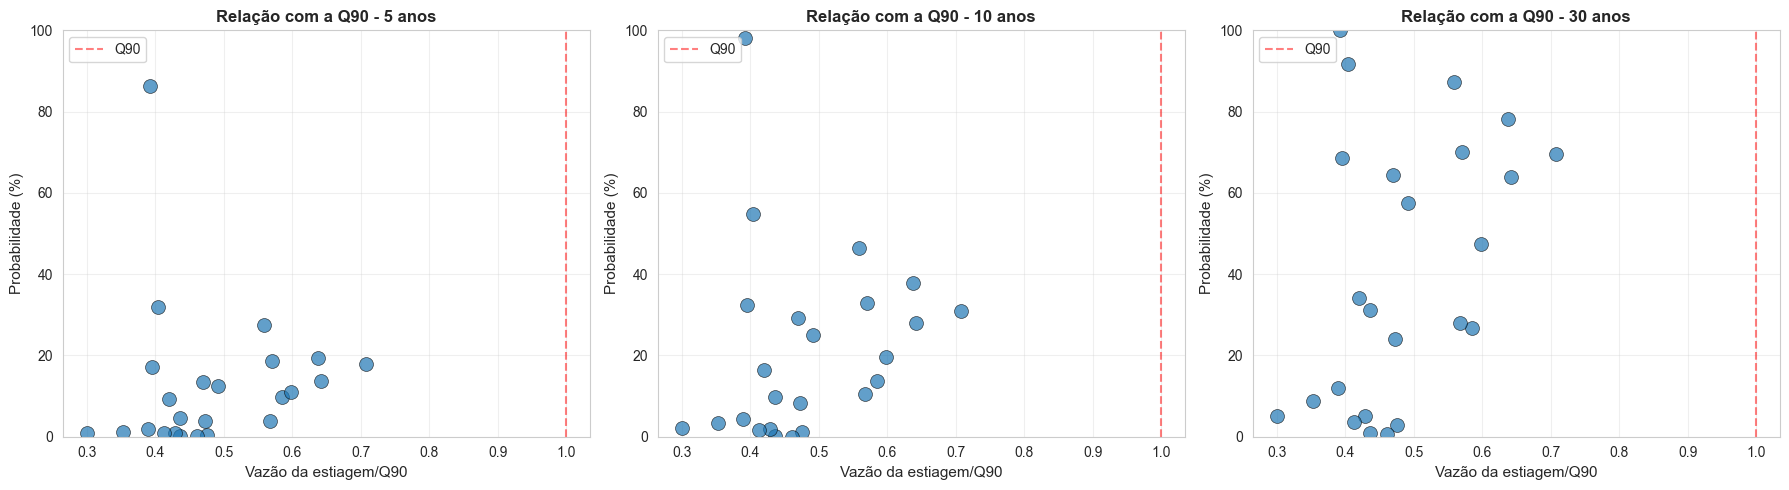

In [22]:
import numpy as np
import pandas as pd

registros = []

for codigo, dict_horizontes in series_vazao_fut.items():
    # características da estiagem observada de referência
    car = caracteristicas_ref[codigo]
    q_limiar = car['q_limiar']
    dur_ref = car['duracao_meses']
    vazao_ref = car['vazao_media_estiagem']  # média da estiagem ref (mensal)

    # dicionários para probabilidades por horizonte
    probs = {}
    
    for h_anos, lista_series in dict_horizontes.items():
        n_sims = len(lista_series)
        n_ocorr = 0

        # opcional: estatísticas de severidade e duração típicas no futuro
        severidades = []
        duracoes = []

        for serie in lista_series:
            # aqui você define COMO detectar estiagens nas séries futuras
            # Exemplo bem genérico (ajuste à sua regra real):
            serie_mensal = serie  # já está mensal
            abaixo_limiar = serie_mensal < q_limiar

            # contar blocos consecutivos abaixo do limiar
            dur_max = 0
            soma_minima = None

            dur_atual = 0
            soma_atual = 0.0
            for val, flag in zip(serie_mensal.values, abaixo_limiar.values):
                if flag:
                    dur_atual += 1
                    soma_atual += val
                else:
                    if dur_atual >= dur_ref:
                        media_evento = soma_atual / dur_atual
                        if media_evento <= vazao_ref:
                            dur_max = max(dur_max, dur_atual)
                            soma_minima = media_evento if soma_minima is None else min(soma_minima, media_evento)
                    dur_atual = 0
                    soma_atual = 0.0

            # checar o último bloco, se a série terminar em estiagem
            if dur_atual >= dur_ref:
                media_evento = soma_atual / dur_atual
                if media_evento <= vazao_ref:
                    dur_max = max(dur_max, dur_atual)
                    soma_minima = media_evento if soma_minima is None else min(soma_minima, media_evento)

            # se houve pelo menos um evento com duração ≥ referência
            if soma_minima is not None:
                n_ocorr += 1
                # severidade = vazão média do pior evento / limiar Q (ou / vazao_ref, se preferir)
                severidade = soma_minima / q_limiar
                severidades.append(severidade)
                duracoes.append(dur_max)

        # probabilidade de pelo menos uma estiagem "análoga" à de referência
        prob = 100 * n_ocorr / n_sims if n_sims > 0 else np.nan
        probs[h_anos] = {
            'prob': prob,
            'sev_med': np.nanmean(severidades) if len(severidades) > 0 else np.nan,
            'dur_med': np.nanmean(duracoes) if len(duracoes) > 0 else np.nan
        }

    # um registro por estação
    registros.append({
        'Codigo': codigo,
        # probabilidades por horizonte
        'Prob_5anos_%':  probs.get(5,  {}).get('prob', np.nan),
        'Prob_10anos_%': probs.get(10, {}).get('prob', np.nan),
        'Prob_30anos_%': probs.get(30, {}).get('prob', np.nan),
        # severidade e duração “médias” associadas ao período ref (para o scatter)
        f'Severidade_{ANO_INICIO}': probs.get(30, {}).get('sev_med', np.nan),
        f'Duracao_{ANO_INICIO}_meses': probs.get(30, {}).get('dur_med', np.nan)
    })

df_monte_carlo = pd.DataFrame(registros)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

periodo_label = f"{ANO_INICIO}" if ANO_INICIO == ANO_FIM else f"{ANO_INICIO}-{ANO_FIM}"
nome_limiar = f'Q{int((1-QUANTIL)*100)}'

horizontes_cols = [
    ('Prob_5anos_%',  '5 anos'),
    ('Prob_10anos_%', '10 anos'),
    ('Prob_30anos_%', '30 anos')
]

# ---------- Histogramas ----------
fig, axes = plt.subplots(1, len(horizontes_cols), figsize=(6*len(horizontes_cols), 5))

for (coluna, titulo), ax in zip(horizontes_cols, axes):
    dados = df_monte_carlo[coluna].dropna()
    ax.hist(dados, bins=20, alpha=0.7, color='steelblue',
            edgecolor='black', density=True)
    dados.plot.kde(ax=ax, color='red', linewidth=2, label='Densidade')

    media = dados.mean()
    mediana = dados.median()
    ax.axvline(media, color='orange', linestyle='--', linewidth=2,
               label=f'Média: {media:.1f}%')
    ax.axvline(mediana, color='green', linestyle='--', linewidth=2,
               label=f'Mediana: {mediana:.1f}%')

    ax.set_xlabel('Probabilidade (%)', fontsize=12)
    ax.set_ylabel('Densidade', fontsize=12)
    ax.set_title(f'Distribuição - Horizonte de {titulo}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()


# Vazao x probabilidade

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

col_severidade = f'Severidade_{periodo_label}'

for idx, (coluna, titulo) in enumerate([('Prob_5anos_%', '5 anos'), 
                                            ('Prob_10anos_%', '10 anos'), 
                                            ('Prob_30anos_%', '30 anos')]):
    ax = axes[idx]
    scatter = ax.scatter(df_monte_carlo[col_severidade], 
                        df_monte_carlo[coluna],
                        s=100,
                        alpha=0.7,
                        edgecolors='black',
                        linewidth=0.5)
    
    # formatação
    ax.set_xlabel(f'Vazão da estiagem/{nome_limiar}', fontsize=11)
    ax.set_ylabel(f'Probabilidade (%)', fontsize=11)
    ax.set_title(f'Relação com a Q90 - {titulo}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Definir limites fixos do eixo y
    ax.set_ylim(0, 100)  # ajuste conforme necessário
    
    # linha de referência
    ax.axvline(1.0, color='red', linestyle='--', alpha=0.5, label=nome_limiar)
    ax.legend()

plt.tight_layout()
plt.show()

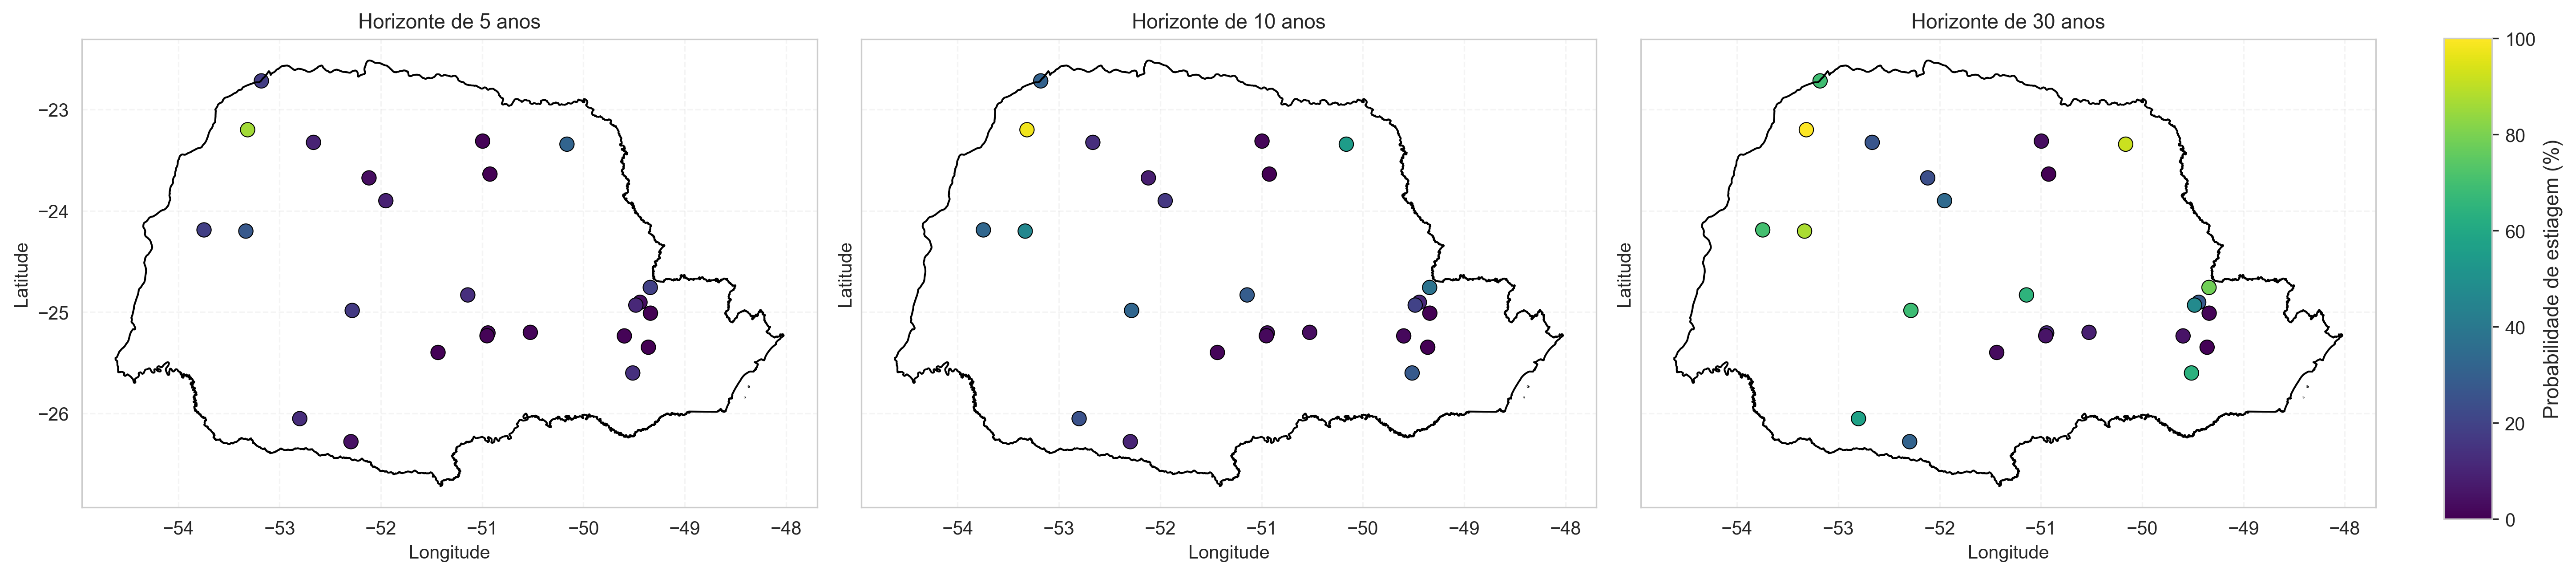

In [25]:
import matplotlib.pyplot as plt
import geopandas as gpd
from geobr import read_state

# --- preparação (igual ao seu código) ---
df_plot = df_filtrado.merge(
    df_monte_carlo,
    left_on='Code',
    right_on='Codigo',
    how='inner'
)

geometry = gpd.points_from_xy(df_plot['Longitude'], df_plot['Latitude'])
gdf_est = gpd.GeoDataFrame(df_plot, geometry=geometry, crs="EPSG:4326")

parana = read_state(code_state=41, year=2020).to_crs("EPSG:4326")

# colunas e títulos dos 3 horizontes
horizontes = [
    ('Prob_5anos_%',  '5 anos'),
    ('Prob_10anos_%', '10 anos'),
    ('Prob_30anos_%', '30 anos')
]

# --- figura com 3 mapas lado a lado ---
fig, axes = plt.subplots(1, 3, figsize=(18, 8), dpi=300, sharex=True, sharey=True)

vmin, vmax = 0, 100  # mesma escala em todos

for ax, (col_prob, titulo) in zip(axes, horizontes):
    # contorno PR
    parana.boundary.plot(ax=ax, linewidth=1.0, color='black')

    # estações
    sc = ax.scatter(
        gdf_est.geometry.x,
        gdf_est.geometry.y,
        c=gdf_est[col_prob],
        cmap='viridis',
        vmin=vmin, vmax=vmax,
        s=60,
        edgecolors='black',
        linewidth=0.5
    )

    ax.set_title(f'Horizonte de {titulo}', fontsize=11)
    ax.set_xlabel('Longitude', fontsize=10)
    ax.set_ylabel('Latitude', fontsize=10)
    ax.set_aspect('equal')
    ax.grid(alpha=0.2, linestyle='--')

# colorbar única para o último scatter (todos usam mesma escala)
fig.subplots_adjust(right=0.88)  # deixa espaço para a barra

# Cria um eixo próprio só para a colorbar (x0, y0, largura, altura em coords da figura)
cax = fig.add_axes([1.02, 0.27, 0.02, 0.45])
cbar = fig.colorbar(sc, cax=cax)
cbar.set_label('Probabilidade de estiagem (%)', fontsize=11)

plt.tight_layout()
plt.show()


In [26]:
import numpy as np
import pandas as pd

print("\n" + "="*80)
print("1) CARACTERIZAÇÃO DAS SÉRIES (Vazão média e CV entre estações)")
print("="*80)

# 1. Caracterização das séries (médias e CV entre estações)
vazoes_medias = []
cvs = []

for serie in series_filtradas.values():
    serie_mensal = serie.resample('M').mean()
    mu = serie_mensal.mean()
    sd = serie_mensal.std()
    vazoes_medias.append(mu)
    cvs.append(sd / mu)

vazoes_medias = pd.Series(vazoes_medias)
cvs = pd.Series(cvs)

print("\nVazão média mensal entre estações (m³/s):")
print(f"  mín  = {vazoes_medias.min():.2f}")
print(f"  med  = {vazoes_medias.median():.2f}")
print(f"  máx  = {vazoes_medias.max():.2f}")

print("\nCoeficiente de variação entre estações (-):")
print(f"  mín  = {cvs.min():.2f}")
print(f"  med  = {cvs.median():.2f}")
print(f"  máx  = {cvs.max():.2f}")


print("\n" + "="*80)
print("2) DISTRIBUIÇÕES TEÓRICAS (df_resumo_fits)")
print("="*80)

# 2. Resumo dos ajustes de distribuições teóricas (df_resumo_fits):
#    assume que df_resumo_fits tem colunas: 'n_dists_aceitas', 'best_dist'
if 'df_resumo_fits' in globals():
    n_aceitas = df_resumo_fits['n_dists_aceitas']

    print("\nNúmero de distribuições aceitas por estação (n_dists_aceitas):")
    print(f"  mín  = {n_aceitas.min():d}")
    print(f"  med  = {int(n_aceitas.median())}")
    print(f"  máx  = {n_aceitas.max():d}")

    print("\nFrequência de estações por número de distribuições aceitas:")
    print(n_aceitas.value_counts().sort_index())

    print("\nDistribuições com maior p-valor (best_dist) - contagem:")
    print(df_resumo_fits['best_dist'].value_counts())
else:
    print("df_resumo_fits não está definido no ambiente atual.")


print("\n" + "="*80)
print("3) DIAGNÓSTICOS ARMA (df_tests)")
print("="*80)

# 3. Testes de resíduos ARMA (df_tests):
#    assume colunas: 'Ljung-Box', 'Breusch-Pagan', 'Shapiro-Wilk'
if 'df_tests' in globals():
    alpha = 0.05
    lj_ok = (df_tests['Ljung-Box'] > alpha)
    bp_ok = (df_tests['Breusch-Pagan'] > alpha)
    sh_ok = (df_tests['Shapiro-Wilk'] > alpha)

    print(f"\nTotal de séries avaliadas: {len(df_tests)}")
    print(f"Séries com Ljung-Box p > {alpha}: {lj_ok.sum()}")
    print(f"Séries com Breusch-Pagan p > {alpha}: {bp_ok.sum()}")
    print(f"Séries com Shapiro-Wilk p > {alpha}: {sh_ok.sum()}")

    conj_ok = lj_ok & bp_ok
    print(f"\nSéries que passam simultaneamente em Ljung-Box e Breusch-Pagan: {conj_ok.sum()}")
else:
    print("df_tests não está definido no ambiente atual.")


print("\n" + "="*80)
print("4) VALIDAÇÃO DAS SÉRIES SINTÉTICAS (df_valid)")
print("="*80)

# 4. Validação (df_valid):
#    assume colunas: 'mu_orig', 'mu_sint_med', 'sd_orig', 'sd_sint_med'
if 'df_valid' in globals():
    # evitar divisão por zero
    mu_rel_bias = (df_valid['mu_sint_med'] - df_valid['mu_orig']) / df_valid['mu_orig'].replace(0, np.nan) * 100
    sd_rel_bias = (df_valid['sd_sint_med'] - df_valid['sd_orig']) / df_valid['sd_orig'].replace(0, np.nan) * 100

    print("\nViés relativo da média (%) entre estações:")
    print(f"  mín    = {mu_rel_bias.min():.1f}")
    print(f"  p25    = {mu_rel_bias.quantile(0.25):.1f}")
    print(f"  med    = {mu_rel_bias.median():.1f}")
    print(f"  p75    = {mu_rel_bias.quantile(0.75):.1f}")
    print(f"  máx    = {mu_rel_bias.max():.1f}")

    print("\nViés relativo do desvio-padrão (%) entre estações:")
    print(f"  mín    = {sd_rel_bias.min():.1f}")
    print(f"  p25    = {sd_rel_bias.quantile(0.25):.1f}")
    print(f"  med    = {sd_rel_bias.median():.1f}")
    print(f"  p75    = {sd_rel_bias.quantile(0.75):.1f}")
    print(f"  máx    = {sd_rel_bias.max():.1f}")
else:
    print("df_valid não está definido no ambiente atual.")


print("\n" + "="*80)
print("5) PROBABILIDADES DE ESTIAGEM (df_montecarlo)")
print("="*80)

# 5. Probabilidades de estiagem (df_montecarlo):
#    assume colunas: 'Prob5anos', 'Prob10anos', 'Prob30anos' em %
if 'df_monte_carlo' in globals():
    for col in ['Prob_5anos_%', 'Prob_10anos_%', 'Prob_30anos_%']:
        if col in df_monte_carlo.columns:
            serie_prob = df_monte_carlo[col].dropna()
            print(f"\nResumo de {col} (%):")
            print(f"  mín    = {serie_prob.min():.1f}")
            print(f"  p25    = {serie_prob.quantile(0.25):.1f}")
            print(f"  med    = {serie_prob.median():.1f}")
            print(f"  p75    = {serie_prob.quantile(0.75):.1f}")
            print(f"  máx    = {serie_prob.max():.1f}")
        else:
            print(f"\nColuna {col} não encontrada em df_montecarlo.")
else:
    print("df_montecarlo não está definido no ambiente atual.")



1) CARACTERIZAÇÃO DAS SÉRIES (Vazão média e CV entre estações)

Vazão média mensal entre estações (m³/s):
  mín  = 0.45
  med  = 56.27
  máx  = 8069.67

Coeficiente de variação entre estações (-):
  mín  = 0.29
  med  = 0.71
  máx  = 0.96

2) DISTRIBUIÇÕES TEÓRICAS (df_resumo_fits)

Número de distribuições aceitas por estação (n_dists_aceitas):
  mín  = 3
  med  = 6
  máx  = 6

Frequência de estações por número de distribuições aceitas:
n_dists_aceitas
3     1
6    24
Name: count, dtype: int64

Distribuições com maior p-valor (best_dist) - contagem:
best_dist
weibull_min    10
gumbel_r        5
gamma           4
lognorm         3
pearson3        2
gev             1
Name: count, dtype: int64

3) DIAGNÓSTICOS ARMA (df_tests)

Total de séries avaliadas: 25
Séries com Ljung-Box p > 0.05: 25
Séries com Breusch-Pagan p > 0.05: 12
Séries com Shapiro-Wilk p > 0.05: 2

Séries que passam simultaneamente em Ljung-Box e Breusch-Pagan: 12

4) VALIDAÇÃO DAS SÉRIES SINTÉTICAS (df_valid)

Viés relati

In [ ]:
import pandas as pd
import numpy as np

# =============================================================================
# TABELA 1 – ESTAÇÕES SELECIONADAS (características básicas)
# =============================================================================
# Fonte: df_filtrado (gerado no filtro inicial e salvo em estacoes_parana_selecionadas.csv)
cols_t1 = [c for c in [
    'Code', 'Name', 'River', 'Latitude', 'Longitude',
    'Start_Year', 'End_Year', 'Years', 'Data_Percentage'
] if c in df_filtrado.columns]

tabela1 = df_filtrado[cols_t1].copy()

renomear_t1 = {
    'Code': 'Codigo',
    'Name': 'Nome',
    'River': 'Rio',
    'Latitude': 'Latitude',
    'Longitude': 'Longitude',
    'Start_Year': 'Ano_inicial',
    'End_Year': 'Ano_final',
    'Years': 'Anos_de_dados',
    'Data_Percentage': 'Percentual_dados_%'
}
tabela1.rename(columns={k: v for k, v in renomear_t1.items() if k in tabela1.columns},
               inplace=True)

print("\nTabela 1 – Estações selecionadas")
print(tabela1)

# =============================================================================
# TABELA 2 – DISTRIBUIÇÕES TEÓRICAS (mínimos anuais 3 meses)
# =============================================================================
# Fonte: df_resumo_fits (já construído no ajuste das distribuições)
if 'df_resumo_fits' in globals():
    tabela2 = df_resumo_fits.reset_index().copy()  # index = codigo
    renomear_t2 = {
        'codigo': 'Codigo',
        'n_anos': 'N_anos_minimos',
        'n_dists_aceitas': 'N_distribuicoes_aceitas',
        'best_dist': 'Distribuicao_maior_p'
    }
    tabela2.rename(columns={k: v for k, v in renomear_t2.items() if k in tabela2.columns},
                   inplace=True)

    print("\nTabela 2 – Ajuste de distribuições teóricas")
    print(tabela2)
else:
    print("\n[AVISO] df_resumo_fits não encontrado – Tabela 2 não gerada.")



# =============================================================================
# TABELA 4 – ESTATÍSTICAS ORIGINAIS x SINTÉTICAS (30 anos)
# =============================================================================
# Fonte: df_valid (médias e desvios-padrão originais/sintéticos + percentis)
if 'df_valid' in globals():
    tabela4 = df_valid.copy()

    # adicionar vieses relativos (%)
    tabela4['bias_mu_%'] = (tabela4['mu_sint_med'] - tabela4['mu_orig']) \
                           / tabela4['mu_orig'].replace(0, np.nan) * 100
    tabela4['bias_sd_%'] = (tabela4['sd_sint_med'] - tabela4['sd_orig']) \
                           / tabela4['sd_orig'].replace(0, np.nan) * 100

    renomear_t4 = {
        'mu_orig': 'Media_orig_m3s',
        'sd_orig': 'DP_orig_m3s',
        'mu_sint_med': 'Media_sint_med_m3s',
        'mu_sint_p_p1': 'Media_sint_p5_m3s',
        'mu_sint_p_p2': 'Media_sint_p95_m3s',
        'sd_sint_med': 'DP_sint_med_m3s',
        'sd_sint_p_p1': 'DP_sint_p5_m3s',
        'sd_sint_p_p2': 'DP_sint_p95_m3s',
        'bias_mu_%': 'Bias_media_%',
        'bias_sd_%': 'Bias_DP_%'
    }
    tabela4.rename(columns={k: v for k, v in renomear_t4.items() if k in tabela4.columns},
                   inplace=True)

    tabela4.reset_index(names='Codigo', inplace=True)

    print("\nTabela 4 – Estatísticas originais vs sintéticas (30 anos)")
    print(tabela4)
else:
    print("\n[AVISO] df_valid não encontrado – Tabela 4 não gerada.")



Tabela 1 – Estações selecionadas
       Codigo  Latitude  Longitude  Ano_inicial  Ano_final  Anos_de_dados  \
118  64620000  -25.2053   -50.9428         1930       2021             92   
427  81125000  -24.7561   -49.3403         1945       2024             80   
153  64685000  -23.3244   -52.6653         1953       2024             72   
373  65945000  -26.0506   -52.8008         1956       2024             69   
119  64625000  -24.8300   -51.1422         1956       2024             69   
362  65925000  -26.2781   -52.2956         1965       2024             60   
187  64820000  -24.2000   -53.3331         1966       2024             59   
175  64775000  -24.7486   -52.7028         1967       2023             57   
190  64830000  -24.1881   -53.7461         1969       2024             56   
181  64795000  -24.5583   -53.1289         1970       2024             55   
166  64693000  -23.1994   -53.3156         1974       2024             51   
145  64675002  -23.6747   -52.1172        